In [7]:
import pandas as pd
df = pd.read_csv('../data/validation_dataset_testtrain_split.csv', index_col=0)
regions = pd.read_csv('../../ice_floe_validation_dataset/data/metadata/region_definitions.csv', index_col=0)

In [49]:
df_500km = df.loc[df.visible_floes == "yes"]
df_500km = df_500km.loc[df_500km.groupby('region').case_number.idxmin(),
    ["case_number", "region", "start_date", "center_lon", "center_lat", "center_x", "center_y", "satellite"]]

In [51]:

for index, row in df_500km.iterrows():
    center_x = row.center_x
    center_y = row.center_y

    left_x = center_x - 250e3
    bottom_y = center_y - 250e3
    right_x = center_x + 250e3
    top_y = center_y + 250e3

    if left_x < regions.loc[row.region, 'left_x']:
        left_x = regions.loc[row.region, 'left_x']
        right_x = left_x + 500e3
    if right_x > regions.loc[row.region, 'right_x']:
        right_x = regions.loc[row.region, 'right_x']
        left_x = right_x - 500e3
    if bottom_y < regions.loc[row.region, 'lower_y']:
        bottom_y = regions.loc[row.region, 'lower_y']
        top_y = bottom_y + 500e3
    if top_y > regions.loc[row.region, 'upper_y']:
        top_y = regions.loc[row.region, 'upper_y']
        bottom_y = top_y - 500e3

    df_500km.loc[index, 'left_x'] = left_x
    df_500km.loc[index, 'right_x'] = right_x
    df_500km.loc[index, 'lower_y'] = bottom_y
    df_500km.loc[index, 'upper_y'] = top_y

    center_x = 0.5 * (left_x + right_x)
    center_y = 0.5 * (bottom_y + top_y)
    df_500km.loc[index, 'new_center_x'] = center_x
    df_500km.loc[index, 'new_center_y'] = center_y

    df_500km.loc[index, 'filename'] = '{cn}-{region}-100km-{date}-{satellite}-250m'.format(cn=str(row.case_number).zfill(3),
                                                                                           region=row.region,
                                                                                           date=pd.to_datetime(row.start_date).strftime('%Y%m%d'),
                                                                                           satellite=row.satellite)
    

In [59]:
import pyproj
# Setup the polar stereographic coordinate arrays
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS('epsg:3413')
transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
lon, lat = transformer_ll.transform(df_500km['new_center_x'], df_500km['new_center_y'])
df_500km['new_center_lat'] = lat
df_500km['new_center_lon'] = lon


lon, lat = transformer_ll.transform(df_500km['right_x'], df_500km['upper_y'])
df_500km['upper_right_lat'] = lat
df_500km['upper_right_lon'] = lon

lon, lat = transformer_ll.transform(df_500km['left_x'], df_500km['lower_y'])
df_500km['lower_left_lat'] = lat
df_500km['lower_left_lon'] = lon



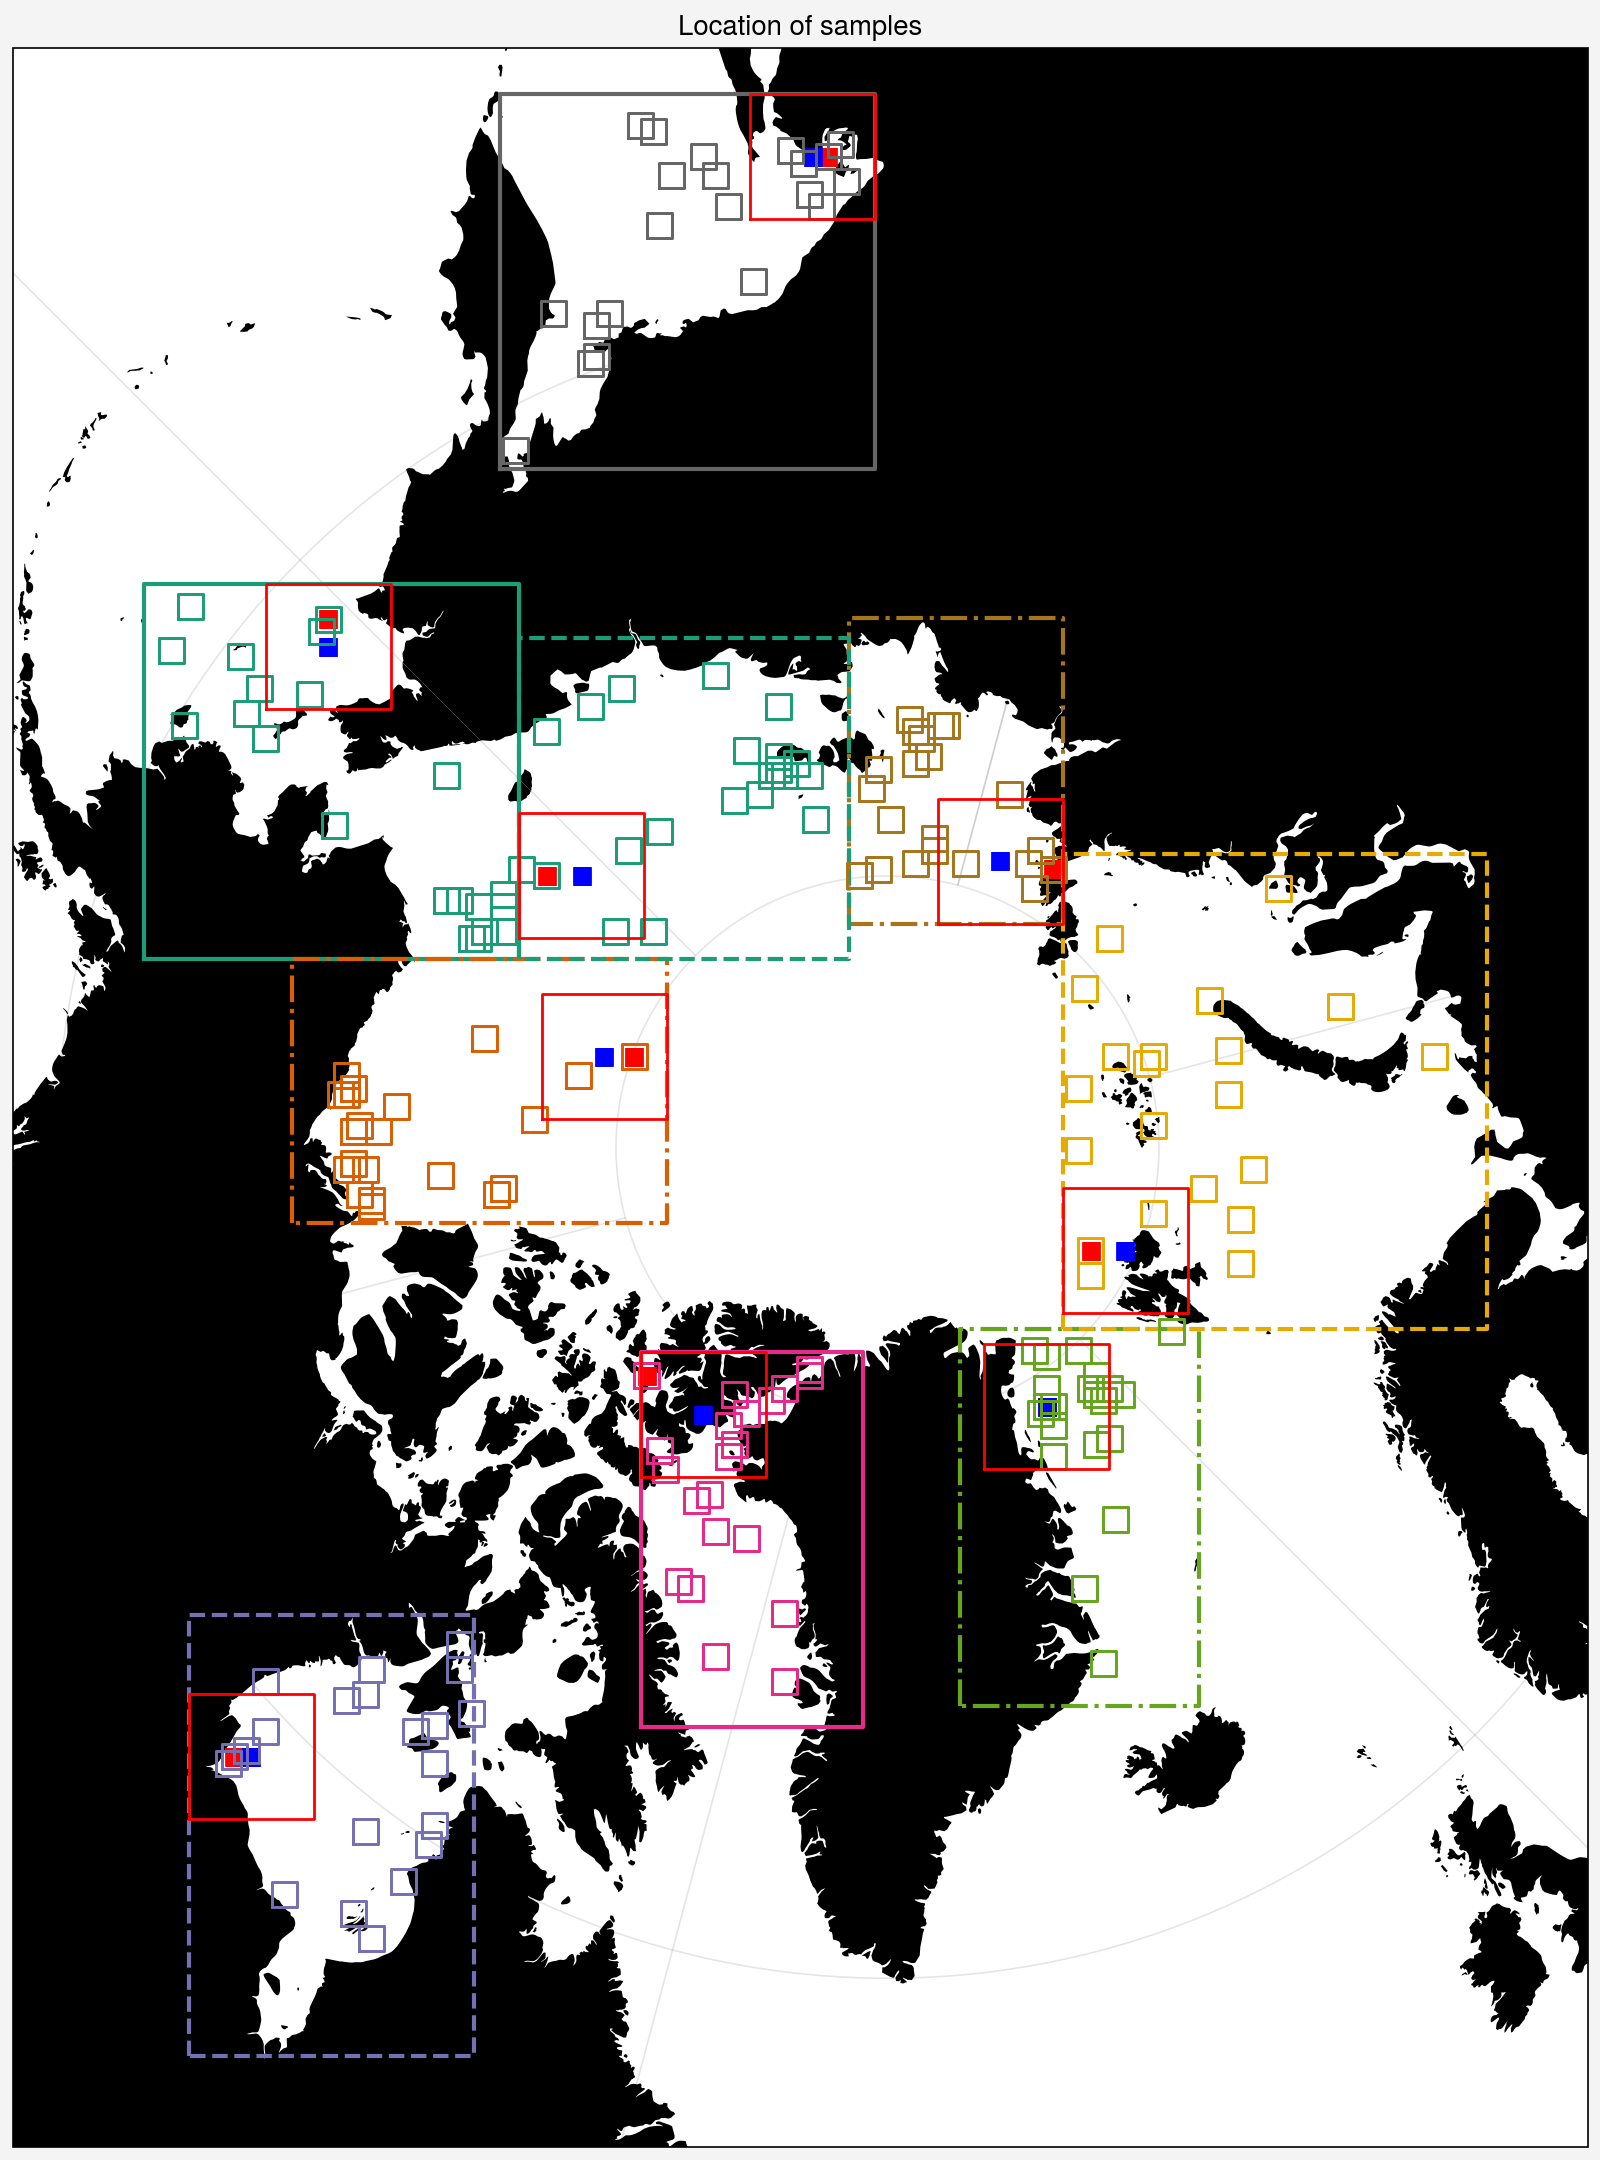

In [54]:
import ultraplot as pplt
import cartopy.crs as ccrs
import numpy as np

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for idx, row in regions.iterrows():
    if row.print_title == 'Barents Kara Seas':
        regions.loc[idx, 'print_title'] = 'Barents-Kara Seas'
    if row.print_title == 'Bering Chukchi Seas':
        regions.loc[idx, 'print_title'] = 'Bering-Chukchi Seas'

pplt.rc['geo.round'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = pplt.subplots(share=False, width=8,
    proj='npstere', proj_kw={'lon_0': -45})


ax.format(land=True, landzorder=0)

ice_floes_cases = df.loc[df.visible_floes == 'yes']
no_floes_cases = df.loc[df.visible_floes == 'no']

for idx, region, lat, lon in zip(range(len(regions)), regions.index, regions.center_lat, regions.center_lon):

    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']].astype(float))
    
    ax.plot(xbox, ybox, transform=crs,
            label='({n}) {t}'.format(n=idx + 1, t=regions.loc[region, 'print_title']), 
               color=colors[region], ls=linestyles[region], m='', zorder=5, lw=1.5)
    
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)

for idx, case in df.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    left = x0 - 50e3
    right = x0 + 50e3
    bottom = y0 - 50e3
    top = y0 + 50e3 
    region = case.region
    if str(case.case_number).zfill(3) in no_floes_cases.index:
        c = 'light gray'
        z = 1
        ax.plot(x0, y0, m='s', color=c, alpha=0.5, s=5, transform=crs, label='', zorder=0)
    else:
        c = colors[region]
        z = 20
    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='',
            transform=crs, color=c, lw=1, zorder=z)

for idx, case in df_500km.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    ax.plot(x0, y0, transform=crs, color='r', marker='s')
    ax.plot(case.new_center_lon, case.new_center_lat,transform=ccrs.PlateCarree(), color='b', marker='s')

    x0 = case.new_center_x
    y0 = case.new_center_y
    left = case.left_x
    right = case.right_x
    bottom = case.lower_y
    top = case.upper_y
    
    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='',
            transform=crs, color='r', lw=1, zorder=z)

ax.format(title='Location of samples')



In [60]:
df_500km[['case_number', 'region', 'start_date',  'lower_left_lat', 'lower_left_lon','upper_right_lat', 'upper_right_lon', 'filename']]

case_number               region  start_date  lower_left_lat  \
0              1           baffin_bay  2022-09-11       74.881549   
42            22    barents_kara_seas  2006-09-09       81.114562   
84            43         beaufort_sea  2019-08-13       77.233824   
128           65  bering_chukchi_seas  2008-05-07       62.430398   
171           86    east_siberian_sea  2006-09-27       74.457376   
210          106        greenland_sea  2014-09-11       77.634370   
254          128           hudson_bay  2019-04-15       55.261626   
294          148           laptev_sea  2011-03-24       81.538635   
340          171       sea_of_okhostk  2009-06-18       56.320310   

     lower_left_lon  upper_right_lat  upper_right_lon  \
0        -81.829695        81.225423       -75.772385   
42         1.609915        78.847801        37.293291   
84      -139.647539        80.096784      -169.720727   
128     -170.175104        62.768830       176.415843   
171     -164.635919        74.822274       171.010271   
210      -28.249735        79.078817         3.416588   
254      -91.132939        61.316062       -91.385543   
294      122.366873        75.653048       108.342036   
340      143.425308        52.459521       135.678541   

                                             filename  
0            001-baffin_bay-100km-20220911-terra-250m  
42     022-barents_kara_seas-100km-20060909-aqua-250m  
84          043-beaufort_sea-100km-20190813-aqua-250m  
128  065-bering_chukchi_seas-100km-20080507-aqua-250m  
171   086-east_siberian_sea-100km-20060927-terra-250m  
210        106-greenland_sea-100km-20140911-aqua-250m  
254           128-hudson_bay-100km-20190415-aqua-250m  
294           148-laptev_sea-100km-20110324-aqua-250m  
340       171-sea_of_okhostk-100km-20090618-aqua-250m

In [46]:
500 / 1953

0.2560163850486431